# Kaggle Project: Titanic Sink 1912 Data Science

## Import Libraries

First of all, we will import the useful packages.

In [120]:
import pandas as pd
import numpy as nu
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## Load Data

In [122]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

## Visualize Data

In [123]:
print "Total Training Data Points: {}".format(len(train_df))
print "Total Test Data Points: {}".format(len(test_df))

Total Training Data Points: 891
Total Test Data Points: 418


These are the various columns in our data set:

In [124]:
print train_df.columns.values

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


Let's look at the count of null records in each column.

In [125]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

As there are lot of empty records in Cabin column, we can ignore the same while building the model.

In [126]:
train_df.drop('Cabin', axis=1, inplace=True)

Further, we see that the ticket number is just an identification and doesn't have in significance in modelling/prediction. Hence, we will ignore this too.

In [127]:
train_df.drop('Ticket', axis=1, inplace=True)

Further 177 records have NaN age, thus we will remove these records.

In [128]:
train_df = train_df[pd.notnull(train_df['Age'])]

This the final information of the train data.

In [129]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    714 non-null int64
Survived       714 non-null int64
Pclass         714 non-null int64
Name           714 non-null object
Sex            714 non-null object
Age            714 non-null float64
SibSp          714 non-null int64
Parch          714 non-null int64
Fare           714 non-null float64
Embarked       712 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 61.4+ KB


Now, Let us look at some records in the final dataset.

In [130]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [131]:
train_df.describe(include=['O'])

,Name,Sex,Embarked
count,714,714,712
unique,714,2,3
top,"Graham, Mr. George Edward",male,S
freq,1,453,554


Let us observe some correlations. It only makes sense so do so for the data which are either categorical, discrete or ordinal.

In [132]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.655914
1,2,0.479769
2,3,0.239437


In [133]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.754789
1,male,0.205298


In [134]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.530055
2,2,0.440000
0,0,0.371550
3,3,0.333333
4,4,0.166667
5,5,0.000000


In [135]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
2,2,0.573529
1,1,0.554545
0,0,0.357006
5,5,0.200000
4,4,0.000000
6,6,0.000000


From above corrrelations, we observe the following inferences:
1. Passenger Class has direct correlation with the survival, as the passengers of Class 1 have almost 65% rate of survival.
2. Females have more survival rate(~74%) as compared to males.
3. Some categories in SibSp and Parch have 0 correlation with the survival rate.

While, building the model, we will heavily use these outcomes.

Further, we will visualize the data using histograms for continuous variable like Age.

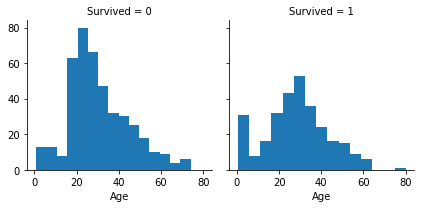

In [136]:
fgrid = sns.FacetGrid(train_df, col='Survived')
fgrid.map(plt.hist, 'Age', bins=15)

Below are the observations from the above histogram:
1. Infants (Age <=4) had high survival rate.
2. Oldest passengers (Age = 80) survived.
3. Large number of 15-25 year olds did not survive.
4. Most passengers are in 15-35 age range.

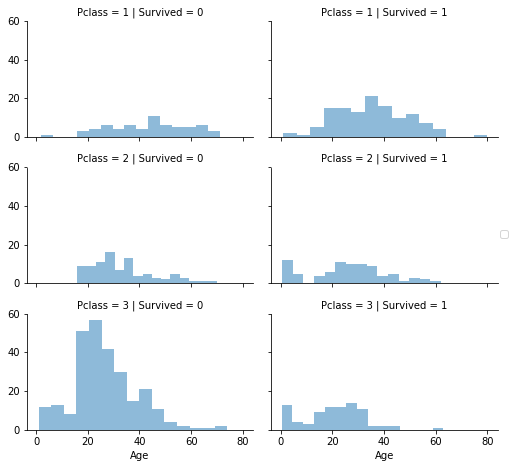

In [137]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=0.5, bins=15)
grid.add_legend()

We see from the Passenger class, Age and Survival histogram that most of the passengers are in class 3 however most of them didn't survive. But if we consider the percentage of passengers, most passengers in class 1 survived. And almost all infants and passengers of age<15 survived in class 2.

Thus Pclass will play a major role in building the model combined with age.

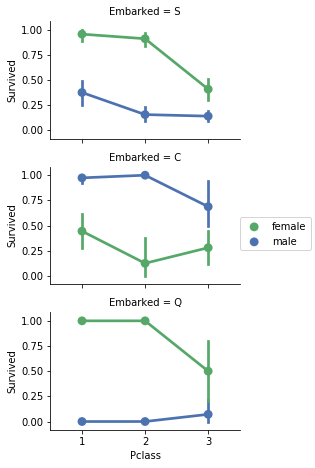

In [138]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

Observations:
1. Female passengers had much better survival rate than males.
2. Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
3. Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports.
4. Ports of embarkation have varying survival rates for Pclass=3 and among male passengers.

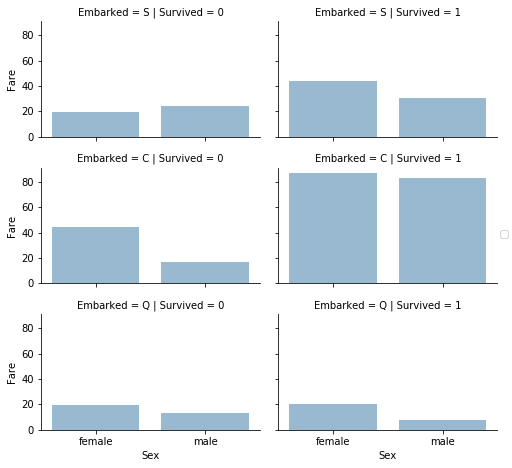

In [139]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=0.5, ci=None)
grid.add_legend()

Observations:
1. Higher fare paying passengers had better survival.
2. Port of embarkation correlates with survival rates.

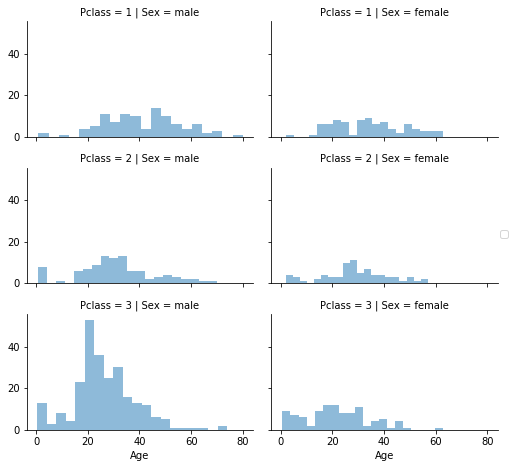

In [140]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=0.5, bins=20)
grid.add_legend()

## Modification in Data

Now, we will change all the features which are string to some ordinal or numeric quantity. Some values are discrete such as Sex, Embarked, for them it is quite easy. Such male can be mapped to 0 and female can be mapped to 1.

But for continuous values such as Age, Fare, we will divide them into multiple beans/buckets and mark them appropriately.

For the name field, useful feature such as Mr. Mrs etc can be extracted and then can be quantified. The actual names can be further dropped.

In [168]:
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

AttributeError: 'DataFrame' object has no attribute 'Name'

In [142]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.583333
1,Miss,0.724832
2,Mr,0.168342
3,Mrs,0.788991
4,Rare,0.363636


In [143]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [144]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((714, 9), (418, 11))

In [145]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


In [146]:
guess_ages = nu.zeros((2,3))
print guess_ages

[[ 0.  0.  0.]
 [ 0.  0.  0.]]


In [148]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [149]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.370690
2,"(32.0, 48.0]",0.403226
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [150]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [151]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


In [152]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.777778
2,3,0.569892
1,2,0.546763
6,7,0.333333
0,1,0.321782
4,5,0.272727
5,6,0.136364
7,8,0.000000


In [153]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.516129
1,1,0.321782


In [154]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [155]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2
10,0,0,3


In [156]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [157]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.607692
2,S,0.365108
1,Q,0.285714


In [158]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


In [169]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3


In [170]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

ValueError: Bin edges must be unique: array([ 0.,  1.,  2.,  3.,  3.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [171]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

ValueError: labels ['FareBand'] not contained in axis

The final sample of test dataset.

In [172]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,0,2,1,1,6
3,895,3,0,1,0,0,1,1,3
4,896,3,1,1,0,0,3,0,3
5,897,3,0,0,0,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,0,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,0,0,1,0,3


I am using SVM for predicting the outputs of the test model.

### TODO: Run the testset with various other models such as Naive Bayes, Logistic Regression, KNN etc.

In [173]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((714, 8), (714,), (418, 8))

In [194]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

81.93

The accuracy of SVM model on the test set came out to be quite okay. It will be exciting to see how it performs with other models.

In [193]:
prediction = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })

print prediction

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
5            897         0
6            898         0
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         0
19           911         0
20           912         0
21           913         0
22           914         1
23           915         0
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         0
391         1283         1
392         1284         0
3